# Chest X-ray Convolutional Neural Networks
Within this notebook, I will be training a CNN to take X-ray images and determine whether or not a patient has pneumonia. 🤓 <br>

![What does pneumonia look like](./project-images/normal-vs-infected.png)

#### Imports: 
My first task is to import the libraries I will be working with. Since I am building a neural network, I will need packages from the tensor flow and keras libraries.

In [172]:
# The usual suspects 😆
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import scipy
import warnings
warnings.filterwarnings('ignore')
# preprocessing
import os, shutil
import time
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
# Deep learning
from keras import models, layers
from keras.models import load_model

# metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# optimizers
from keras.optimizers import SGD
from keras.optimizers import adam

#### My functions:

In [67]:
def plot_results(fitted_model):
    """This function takes a history object from a CNN andplots the results in a scatter chart"""
    hist_cnn = fitted_model.history
    loss_values = hist_cnn['loss']
    val_loss_values = hist_cnn['val_loss']
    acc_values = hist_cnn['acc'] 
    val_acc_values = hist_cnn['val_acc']


    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'g.', label='Training loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, acc_values, 'r.', label='Training acc')
    plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return 

## The Data 😎
The next step is to load the data. In this case, my data will be all x-ray images. The train, validation, and test data are all organized in a directory in this repo.

In [164]:
# Directories:

# Train
train = '../data/chest-x-rays/chest_xray/split/train'
# Validation
val = '../data/chest-x-rays/chest_xray/split/val'
# Test
test = '../data/chest-x-rays/chest_xray/split/test'


In [170]:
! cd ../data
! ls

Presentation1.pdf  README.md          index.ipynb
Presentation1.pptx index.html


## Creating our data frame
In this section I will use imagedatagenerator from the keras preprocessing library to create my training data set. Since CNN's require the image size to be 256ppi or less, I will resize my images, create a random seed to reproduce the work, and limit my batch size (so i don't tax my computer too much).

In [3]:
# use the generator to make our data sets
train_gen = ImageDataGenerator(rescale= 1./255).flow_from_directory(
                directory=train,
                batch_size=1000,
                target_size=(256,256),
                seed=15                
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
                directory=val,
                batch_size=16,
                target_size=(256,256),
                seed=15
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
                directory=test,
                batch_size=624,
                target_size=(256,256),
                seed=15
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# get the shape of our data
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)
print('------------------------Train-----------------------')
print("We have a train batch size of:", train_images.shape[0])
print("The train images have a:", train_images.shape[1], "X", train_images.shape[2], "ppi")
print("The train images have:", train_images.shape[3], "layers (Red, Green, Blue)")
print("Train labels shape:", train_labels.shape)

print('---------------------Validation---------------------')
print("We have a validation batch size of:", val_images.shape[0])
print("The validation images have a:", val_images.shape[1], "X", val_images.shape[2], "ppi")
print("The validation images have:", val_images.shape[3], "layers (Red, Green, Blue)")
print("Val labels shape:", val_labels.shape)

print('------------------------Test------------------------')
print("We have a test batch size of:", test_images.shape[0])
print("The test images have a:", test_images.shape[1], "X", test_images.shape[2], "ppi")
print("The test images have:", test_images.shape[3], "layers (Red, Green, Blue)")
print("Test labels shape:", test_labels.shape)
print('----------------------------------------------------')

------------------------Train-----------------------
We have a train batch size of: 1000
The train images have a: 256 X 256 ppi
The train images have: 3 layers (Red, Green, Blue)
Train labels shape: (1000, 2)
---------------------Validation---------------------
We have a validation batch size of: 16
The validation images have a: 256 X 256 ppi
The validation images have: 3 layers (Red, Green, Blue)
Val labels shape: (16, 2)
------------------------Test------------------------
We have a test batch size of: 624
The test images have a: 256 X 256 ppi
The test images have: 3 layers (Red, Green, Blue)
Test labels shape: (624, 2)
----------------------------------------------------


## Viewing our labels
We will see below that our labels are 1 and 0. This on and off binary indicated whether our chest x ray has pneumonia or not.

In [128]:
# View our data set labels limit them to 10
print('------------------------Train-----------------------')
print(train_labels[:10])
print('---------------------Validation---------------------')
print(val_labels[:10])
print('------------------------Test------------------------')
print(test_labels[:10])
print('----------------------------------------------------')

------------------------Train-----------------------
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
---------------------Validation---------------------
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
------------------------Test------------------------
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
----------------------------------------------------


We know that for this problem we are dealing with only 2 outcomes pnuemonia or normal. The labels show 2 columns of binary numbers essentially showing the same thing. 1 column tells us all we need to know if its 1 then they are infected, if its 2 they are normal. With that said lets reshape our labels to only show 1 columns.

In [6]:
# use the numpy reshape function and pass through all rows and only the first column
train_y = np.reshape(train_labels[:,0], (1000,1))
val_y = np.reshape(val_labels[:,0], (16, 1))
test_y = np.reshape(test_labels[:,0], (624,1))
# Lets check if it worked by viewing the first 10
print('------------------------Train-----------------------')
print(train_y[:10,:])
print('---------------------Validation---------------------')
print(val_y[:10,:])
print('------------------------Test------------------------')
print(test_y[:10,:])
print('----------------------------------------------------')

------------------------Train-----------------------
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]
---------------------Validation---------------------
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
------------------------Test------------------------
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
----------------------------------------------------


Great! it worked.

In [7]:
# Resampling the images this code essentially multiplies the images pixel density by the number of layers (RGB)
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(1000, 196608)
(16, 196608)
(624, 196608)


Everything looks good let's do our train, test, and validation split.

## Exploratory Data Analysis 
lets take a loot at how our data sets are being viewed after the resize.

------------------------Train-----------------------


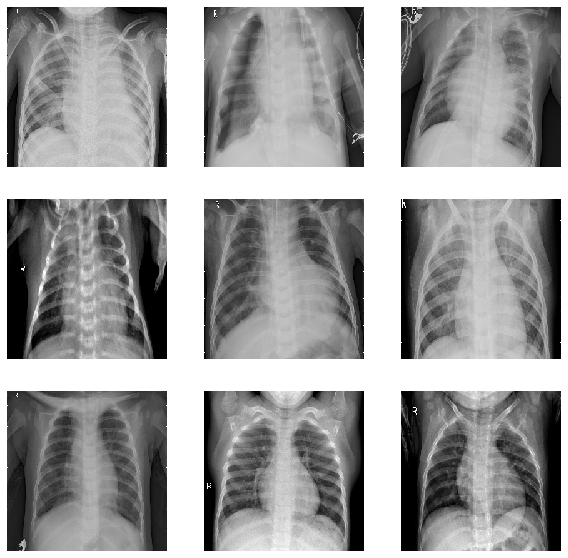

In [8]:
print('------------------------Train-----------------------')
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()

---------------------Validation---------------------


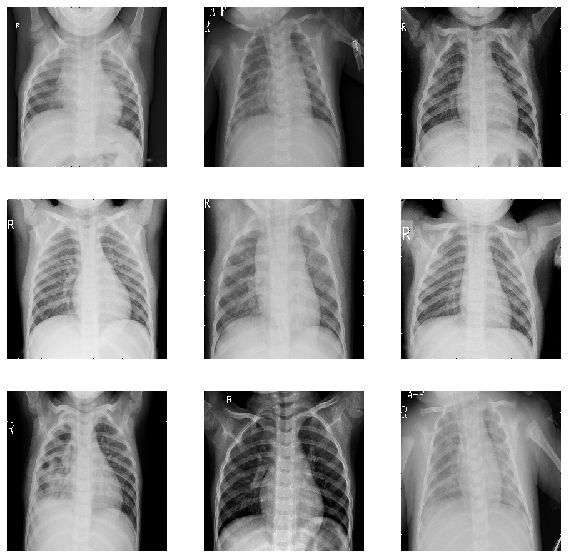

In [9]:
print('---------------------Validation---------------------')
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(val_images[i])
    plt.axis('off')
plt.show()

------------------------Test------------------------


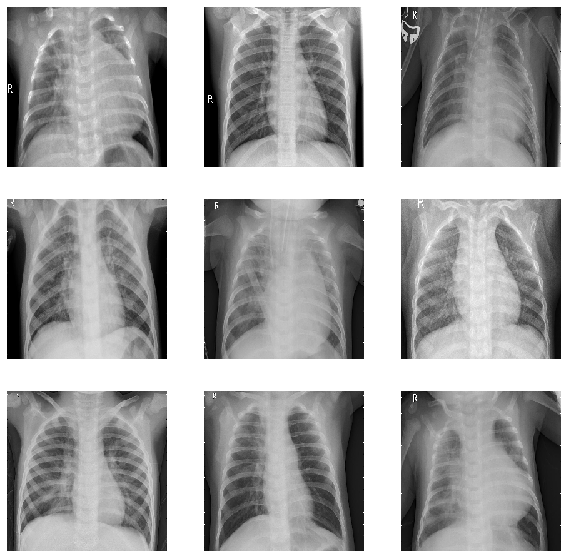

In [10]:
print('------------------------Test------------------------')
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()

## Building my baseline model
In this section I will be setting up the model and adding the layers to it.

In [11]:
# Create our random seed so that we can replicate the results
np.random.seed(15)
# instantiate the model we will use
model = models.Sequential()
# Add our first layer with our nodes and provide our activater and input shape (the input shape is 256*256*3 the pixel size and color layers)
model.add(layers.Dense(20, activation='relu', input_shape=(196608,)))
# add another hidden layer for nodes
model.add(layers.Dense(7, activation='relu'))
# add another layer of nodes
model.add(layers.Dense(5, activation='relu'))
# add the final output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
# compile our neural network and apply a learner and loss function, in this case i will use accuracy as a metric
model.compile(optimizer='sgd',
                loss='binary_crossentropy',
                metrics=['accuracy']
)
# fit the model to our train set to learn the patterns and then check the unseen validation set to compare its accuracy
model.fit(train_img,
            train_y,
            epochs=50,
            batch_size=32,
            validation_data=(val_img, val_y)
)

Train on 1000 samples, validate on 16 samples
Epoch 1/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5958 - accuracy: 0.7580 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6840 - accuracy: 0.7360 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6660 - accuracy: 0.7560 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6508 - accuracy: 0.7560 - val_loss: 0.6990 - val_accuracy: 0.5000
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6377 - accuracy: 0.7560 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6266 - accuracy: 0.7560 - val_loss: 0.7072 - val_accuracy: 0.5000
Epoch 7/50
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6170 - accur

In [13]:
# Evaluate our model
result_train = model.evaluate(train_img, train_y)

1000/1000 [==============================] - 1s 610us/step


In [21]:
# Evaluate with our test set
result_test = model.evaluate(test_img, test_y)

608/624 [============================>.] - ETA: 624/624 [==============================] - 5s 7ms/step


In [22]:
# Loss and accuracy results:
print('------------------------Train-----------------------')
print("train loss:",round(result_train[0],2))
print("train accuracy", round(result_train[1],2))
print('------------------------Test------------------------')
print("validation loss:", round(result_test[0],2))
print("validation accuracy", round(result_test[1],2))
print('----------------------------------------------------')

------------------------Train-----------------------
train loss: 0.56
train accuracy 0.76
------------------------Test------------------------
validation loss: 0.7
validation accuracy 0.62
----------------------------------------------------


The model is pretty bad and only got an accuracy of 62% on our test data. It's validation accuracy was a consistent 50%, that means it guessed the same thing over and over.

## Building the CNN
I will add convolutional layers and pooling layers this time and see how it performs.

In [24]:
# instantiate our model
cnn_model = models.Sequential()
# apply our first convolutional layer with our nodes extracts patterns from the images
cnn_model.add(layers.Conv2D(64, 
                kernel_size= (3,3), 
                input_shape=(256,256,3),
                activation='relu'

))
# apply our first pooling layer
cnn_model.add(layers.MaxPooling2D(
                    pool_size = (2,2)
))
# apply our 2nd layer with more nodes
cnn_model.add(layers.Conv2D(32, 
                kernel_size=(3,3),
                input_shape=(256,256,3),
                activation='relu')
)
# apply another pooling layer
cnn_model.add(layers.MaxPooling2D(
                pool_size= (2,2),
))
# compress all the matrices 
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, 
                activation='relu')
)
# add our output layer
cnn_model.add(layers.Dense(1,
                activation='sigmoid')
)
# compile and add our loss function and optimizer
cnn_model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [25]:
# check to see how the our model looks after all the added layers
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                3936288   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [64]:
# for the model to my train set apply epochs (the amount of times it forward and back propagates)
model_1 = cnn_model.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_y)
)

Train on 1000 samples, validate on 16 samples
Epoch 1/10
1000/1000 [==============================] - 167s 167ms/step - loss: 9.7502e-05 - acc: 1.0000 - val_loss: 0.9326 - val_acc: 0.7500
Epoch 2/10
1000/1000 [==============================] - 103s 103ms/step - loss: 9.4850e-05 - acc: 1.0000 - val_loss: 0.8715 - val_acc: 0.7500
Epoch 3/10
1000/1000 [==============================] - 144s 144ms/step - loss: 8.7938e-05 - acc: 1.0000 - val_loss: 0.9344 - val_acc: 0.7500
Epoch 4/10
1000/1000 [==============================] - 132s 132ms/step - loss: 8.4847e-05 - acc: 1.0000 - val_loss: 1.0104 - val_acc: 0.7500
Epoch 5/10
1000/1000 [==============================] - 121s 121ms/step - loss: 8.1907e-05 - acc: 1.0000 - val_loss: 0.8588 - val_acc: 0.7500
Epoch 6/10
1000/1000 [==============================] - 112s 112ms/step - loss: 8.2068e-05 - acc: 1.0000 - val_loss: 0.8243 - val_acc: 0.7500
Epoch 7/10
1000/1000 [==============================] - 112s 112ms/step - loss: 7.5417e-05 - acc: 1.00

In [68]:
# Evaluate our models on train and test set
cnn_result_train = cnn_model.evaluate(train_images, train_y)
cnn_result_test = cnn_model.evaluate(test_images, test_y)

624/624 [==============================] - 29s 46ms/step


In [69]:
# Loss and accuracy results:
print('------------------------Train-----------------------')
print("train loss:",round(cnn_result_train[0],2))
print("train accuracy", round(cnn_result_train[1],2))
print('------------------------Test------------------------')
print("test loss:", round(cnn_result_test[0],2))
print("test accuracy", round(cnn_result_test[1],2))
print('----------------------------------------------------')

------------------------Train-----------------------
train loss: 0.0
train accuracy 1.0
------------------------Test------------------------
test loss: 2.67
test accuracy 0.75
----------------------------------------------------


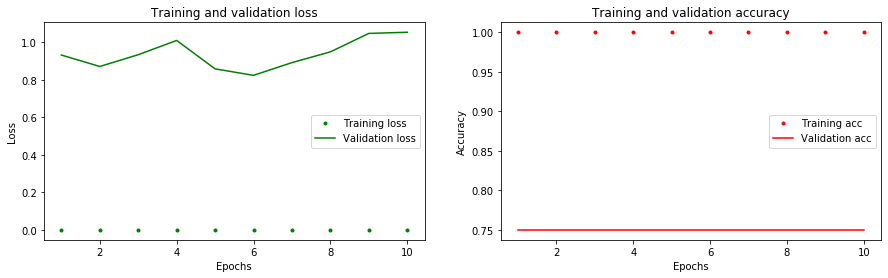

In [71]:
# Use our created function to plot our history object and see the results of accuracy and loss
plot_results(model_1)

The accuracy was only 76% on this one let me see if i can tweak more parameters and make a better model. I will change my learning rate and try a different optimizer.

In [46]:
# increase learning rate to 1% from default .1%
sgd= SGD(learning_rate=0.01, momentum=0.5, nesterov=True)

# instantiate new model
cnn_model2 = models.Sequential()
# apply layers
cnn_model2.add(layers.Conv2D(64, 
                kernel_size= (3,3), 
                input_shape=(256,256,3),
                activation='relu'

))
cnn_model2.add(layers.MaxPooling2D(
                    pool_size = (2,2)
))
cnn_model2.add(layers.Conv2D(32, 
                kernel_size=(3,3),
                input_shape=(256,256,3),
                activation='relu')
)
cnn_model2.add(layers.MaxPooling2D(
                pool_size= (2,2),
))
# compile layers
cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(32, 
                activation='relu')
)
# sigmoid final activation layer (since binary classification)
cnn_model2.add(layers.Dense(1,
                activation='sigmoid')
)
cnn_model2.compile( loss='binary_crossentropy', optimizer= sgd, metrics=['acc'])


In [53]:
# fit to model this time using a smaller batch size
model_2 = cnn_model2.fit(train_images,
                    train_y,
                    epochs=10,
                    batch_size=15,
                    validation_data=(val_images, val_y)
)

Train on 1000 samples, validate on 16 samples
Epoch 1/10
1000/1000 [==============================] - 143s 143ms/step - loss: 0.1296 - acc: 0.9430 - val_loss: 0.7988 - val_acc: 0.6875
Epoch 2/10
1000/1000 [==============================] - 115s 115ms/step - loss: 0.0934 - acc: 0.9680 - val_loss: 0.7513 - val_acc: 0.6875
Epoch 3/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0812 - acc: 0.9740 - val_loss: 0.7094 - val_acc: 0.6875
Epoch 4/10
1000/1000 [==============================] - 114s 114ms/step - loss: 0.0866 - acc: 0.9680 - val_loss: 0.2818 - val_acc: 0.8750
Epoch 5/10
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0692 - acc: 0.9740 - val_loss: 0.6690 - val_acc: 0.7500
Epoch 6/10
1000/1000 [==============================] - 113s 113ms/step - loss: 0.0724 - acc: 0.9780 - val_loss: 0.3393 - val_acc: 0.8125
Epoch 7/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0835 - acc: 0.9690 - val_loss: 0.5134 - val_

In [54]:
# evaluate on test set
cnn2_result_train = cnn_model2.evaluate(train_images, train_y)
cnn2_result_test = cnn_model2.evaluate(test_images, test_y)

624/624 [==============================] - 22s 35ms/step


In [55]:
# Loss and accuracy results:
print('------------------------Train-----------------------')
print("train loss:",round(cnn2_result_train[0],2))
print("train accuracy", round(cnn2_result_train[1],2))
print('------------------------Test------------------------')
print("test loss:", round(cnn2_result_test[0],2))
print("test accuracy", round(cnn2_result_test[1],2))
print('----------------------------------------------------')

------------------------Train-----------------------
train loss: 0.07
train accuracy 0.98
------------------------Test------------------------
test loss: 0.55
test accuracy 0.81
----------------------------------------------------


82% accuracy, this ia a lot better and just by changing our learning rate and optimizer we are able to achieve this.

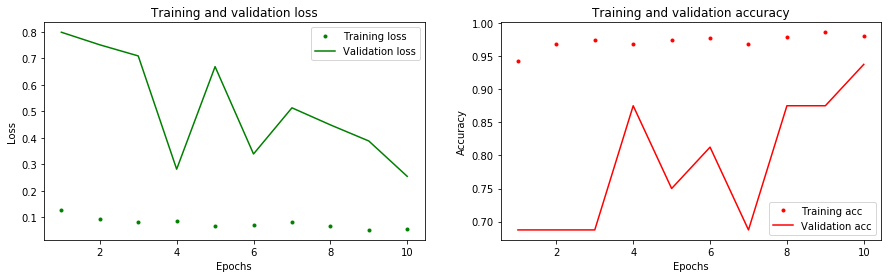

In [63]:
plot_results(model_2)

More tweaking can be done to get a more accurate model but for now i am happy with the results. 

## Threshold selection

In [75]:
# make predictions on test images and check probabilities
probas = cnn_model2.predict_proba(test_images)

In [130]:
probas.max()

0.9987921

I will use baseline threshold of 0.5

In [145]:
predictions_05 = (probas>0.5).astype(int)
predictions_05[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

with this predictions_05 and test_y i should be able to create a confusion matrix using (sklearn) and also get the metrics precision, recall, alpha, power, accuracy. I can try the 3 thresholds 0.5, 0.3, 0.7 and check the matrix. I need to come up with costs for FP,TP,FN,TN.


In [146]:
# Build the confusion matrix based off threshold applied and test predictions
matrix = confusion_matrix(test_y, predictions_05)
matrix

array([[379,  11],
       [107, 127]])

0,0 TN <br>
1,0 FN <br>
1,1 TP <br>
0,1 FP

In [147]:
# extract my values from the matrix
TN = matrix[0][0]
FN = matrix[1][0]
TP = matrix[1][1]
FP = matrix[0][1]

In [148]:
print("TN:",TN)
print("FN:", FN)
print("TP:", TP)
print("FP:",FP)

TN: 379
FN: 107
TP: 127
FP: 11


In [177]:
# 50% threshold metrics
#get a classification report
target_names = ['normal', 'pneumonia']
classification_metrics3 = metrics.classification_report(test_y, predictions_05, target_names = target_names)
print(classification_metrics3)

precision    recall  f1-score   support

      normal       0.78      0.97      0.87       390
   pneumonia       0.92      0.54      0.68       234

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.77       624
weighted avg       0.83      0.81      0.80       624



The cost of a FN is potentially a human life, I will decrease my threshold to try to lower the FN at the cost of increasing FP. I'll set my threshold to .2

In [159]:
predictions_02 = (probas>0.2).astype(int)
predictions_02[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [160]:
matrix2 = confusion_matrix(test_y, predictions_02)
matrix2

array([[374,  16],
       [ 75, 159]])

In [161]:
# extract my values from the matrix
TN2 = matrix2[0][0]
FN2 = matrix2[1][0]
TP2 = matrix2[1][1]
FP2 = matrix2[0][1]

In [162]:
print("TN:",TN2)
print("FN:", FN2)
print("TP:", TP2)
print("FP:",FP2)

TN: 374
FN: 75
TP: 159
FP: 16


In [178]:
# 20% threshold metrics
classification_metrics3 = metrics.classification_report(test_y, predictions_02, target_names = target_names)
print(classification_metrics3)

precision    recall  f1-score   support

      normal       0.83      0.96      0.89       390
   pneumonia       0.91      0.68      0.78       234

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



Now lets compare the thresholds:

In [163]:
# comparison between thresholds
print("----------------Threshold 50%----------------")
print("TN:",TN)
print("FN:", FN)
print("TP:", TP)
print("FP:",FP)
print("----------------Threshold 20%----------------")
print("TN:",TN2)
print("FN:", FN2)
print("TP:", TP2)
print("FP:",FP2)

----------------Threshold 50%----------------
TN: 379
FN: 107
TP: 127
FP: 11
----------------Threshold 20%----------------
TN: 374
FN: 75
TP: 159
FP: 16
